In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipyd
import scipy.misc
from libs import utils


/Users/unahsu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Visualize Convolutional Neural Networks

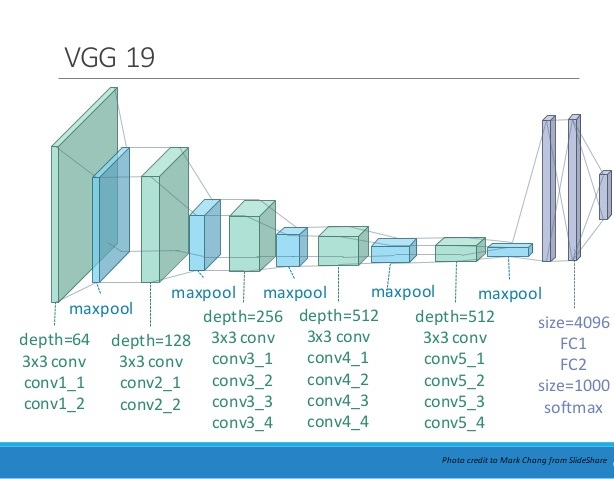

In [3]:
from IPython.display import Image
Image('vgg19.jpg')

In [5]:
from libs import vgg19

#start an interactive session
sess = tf.InteractiveSession()

images = tf.placeholder(tf.float32, [1, 224, 224, 3])
train_mode = tf.placeholder(tf.bool)

#load the model
vgg = vgg19.Vgg19()
vgg.build(images, train_mode)

sess.run(tf.global_variables_initializer())

In [6]:
g = tf.get_default_graph()
names = [op.name for op in g.get_operations()]
print('Sample of available operations: \n',names[:10])

Sample of available operations: 
 ['Placeholder', 'Placeholder_1', 'Placeholder_2', 'Placeholder_3', 'mul/y', 'mul', 'Const', 'split/split_dim', 'split', 'sub/y']


The input to the graph is stored in the first tensor output, and the probability of the 1000 possible objects is in the last probability layer:

In [7]:
input_name = names[0] + ':0'
x = g.get_tensor_by_name(input_name)
x

<tf.Tensor 'Placeholder:0' shape=(1, 224, 224, 3) dtype=float32>

In [8]:
softmax = g.get_tensor_by_name(names[-2] + ':0')
#or use this: softmax = vgg.prob
softmax

<tf.Tensor 'prob:0' shape=(1, 1000) dtype=float32>

/Users/unahsu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


image shape:  (224, 224, 3)


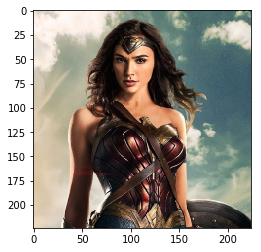

In [9]:
processed_img = utils.load_image('wonder-woman.jpg')

plt.imshow(processed_img)
print('image shape: ', processed_img.shape)

Our images must be shaped as a 4-dimensional shape describing the number of images, height, width, and number of channels before being fed into the network. So our original 3-dimensional image of height, width, channels needs an additional dimension on the 0th axis.

In [12]:
processed_img_4d = processed_img[np.newaxis]
print(processed_img_4d.shape)

(1, 224, 224, 3)


In [13]:
result = np.squeeze(softmax.eval(feed_dict={images: processed_img_4d, train_mode: False}))

In [18]:
utils.print_prob(result)

('Top1: ', ['maillot'], 0.51197773)
('Top5: ', [(['maillot'], 0.51197773), (['bikini,', 'two-piece'], 0.13349892), (['miniskirt,', 'mini'], 0.12154531), (['maillot,', 'tank', 'suit'], 0.051042523), (['gown'], 0.029725686)])


### Visualizing Filters  
Let's try to first visualize the weights of the convolution filters to somehow help us understand what is happening inside the network.

In [19]:
W_vgg = vgg.data_dict['conv1_1'][0]
print(W_vgg.shape)

(3, 3, 3, 64)


Let's look at every single individual filter in the first convolutional layer. We will see a total of 192 feature maps (64 filters * 3 channels).

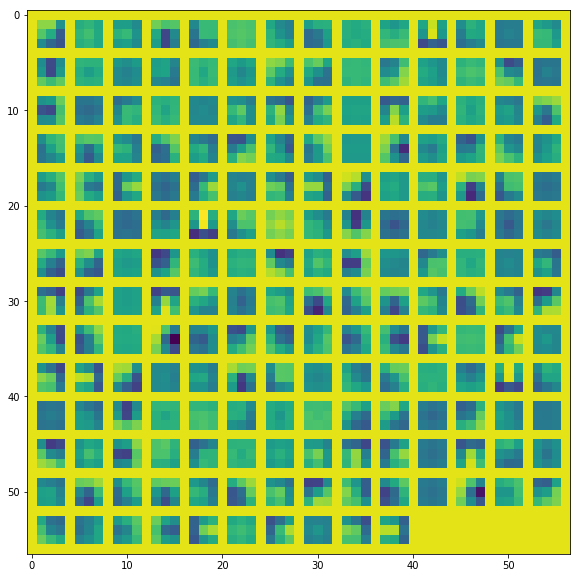

In [20]:
W_montage = utils.montage_filters(W_vgg)
plt.figure(figsize=(10,10))
plt.imshow(W_montage, interpolation='nearest')

### Visualizing Convolutional Output  
Also we can take a look at the convolutional output. We've just seen what each of the convolution filters look like. Let's try to see how they filter the image now by looking at the resulting convolution.

In [21]:
vgg_conv1_1 = vgg.conv1_1.eval(feed_dict={images: processed_img_4d, train_mode:False}) 
vgg_conv2_1 = vgg.conv2_1.eval(feed_dict={images: processed_img_4d, train_mode:False})
vgg_conv5_1 = vgg.conv5_1.eval(feed_dict={images: processed_img_4d, train_mode:False})

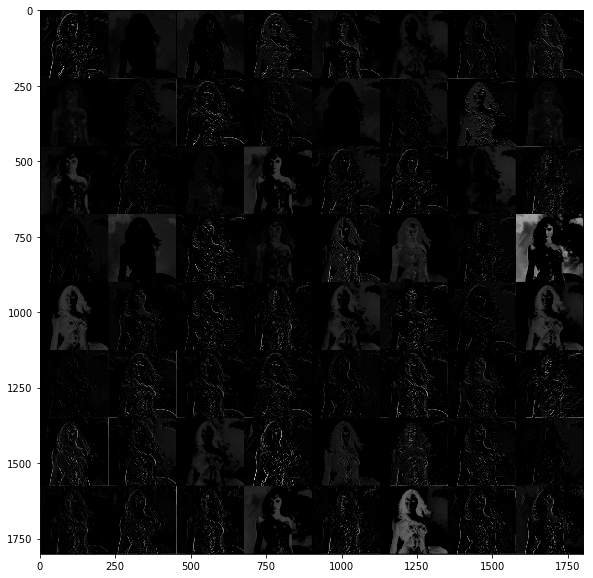

In [22]:
feature = vgg_conv1_1
montage = utils.montage_filters(np.rollaxis(np.expand_dims(feature[0], 3), 3, 2))
plt.figure(figsize=(10, 10))
plt.imshow(montage, cmap='gray')

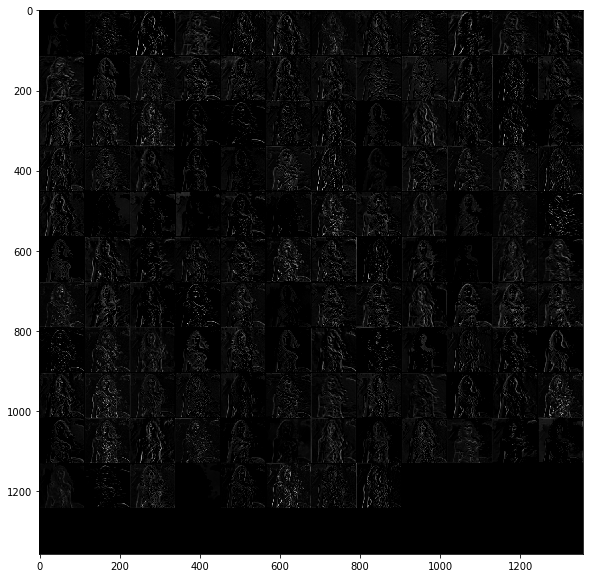

In [23]:
feature = vgg_conv2_1
montage = utils.montage_filters(np.rollaxis(np.expand_dims(feature[0], 3), 3, 2))
plt.figure(figsize=(10, 10))
plt.imshow(montage, cmap='gray')

In [25]:
# max pooling 2X2
layer_shape = tf.shape(feature).eval(feed_dict={images:processed_img_4d, train_mode:False})
print(layer_shape)

[  1 112 112 128]


Our original image which was 1 x 224 x 224 x 3 color channels, now has 128 new channels of information. Some channels capture edges of the body, some capture the face.  
We can also try to visualize some features from higher levels.

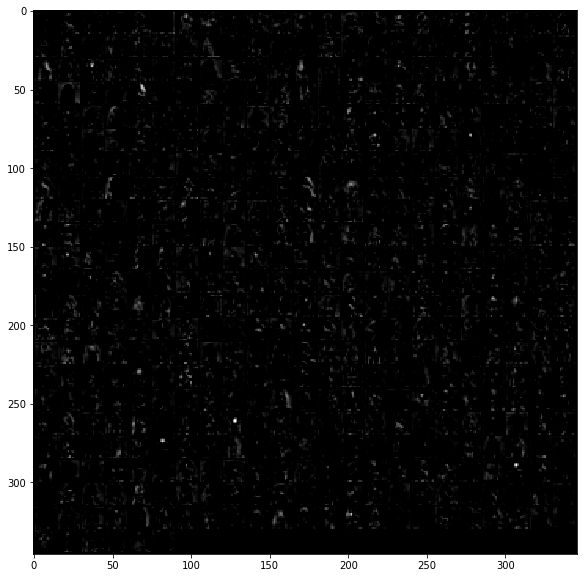

In [26]:
feature = vgg_conv5_1
montage = utils.montage_filters(np.rollaxis(np.expand_dims(feature[0], 3), 3, 2))
plt.figure(figsize=(10, 10))
plt.imshow(montage, cmap='gray')

### Visualizing Gradient  
視覺化卷積輸出是一種非常有用的視覺化淺卷積層的科技，但是當我們到達更深層次時，我們有許多不同的資訊通道被饋送到一些非常高維度的更深的卷積濾波器。僅僅通過看卷積輸出就很難理解它們。  
如果我們想瞭解更深層次的真實情况，我們可以使用反向傳播科技來顯示特定神經元相對於我們輸入影像的梯度。讓我們想像網絡的梯度當backpropagated對原始輸入影像。這告訴我們哪個點數響應了預測的類或給定的神經元。  
我們將向前傳球最多的層，我們有興趣，然後反向傳播來幫助我們瞭解哪些點數貢獻最大的那層最後的啟動。
我們首先創建一個操作，它將找到一個層中所有啟動的最大神經元，然後計算該目標相對於輸入影像的梯度。

In [27]:
feature = vgg.conv4_2
gradient = tf.gradients(tf.reduce_max(feature, axis=3), images)

當我們運行這個網絡，我們將說明我們創造的梯度操作，而不是網絡的softmax層。這將運行一個向前支撐到我們要求找到漸變的層，然後運行一個向後支柱直到輸入影像。

In [28]:
res = sess.run(gradient, feed_dict={images: processed_img_4d, train_mode:True})[0]

#look at the range of values
print(np.min(res[0]), np.max(res[0]))

-9221.37 10603.7


很難理解這個值範圍內的梯度。我們所能做的就是使漸變正常化，這樣我們就可以在正常的顏色值範圍內看到它。正火後的梯度值，讓我們想像原始影像的梯度和backpropagated輸出。

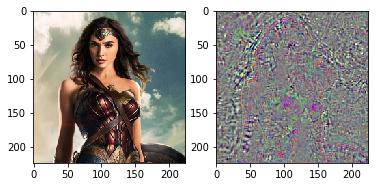

In [31]:
res_normalized = utils.normalize(res)

fig, axs = plt.subplots(1, 2)
plt.figure(figsize=(10,10))
axs[0].imshow(processed_img)
axs[1].imshow(res_normalized[0])

Let's create utility functions which will help us visualize any single neuron in a layer.

In [30]:
def compute_gradient_single_neuron(feature, neuron_i):
    '''visualize a single neuron in a layer, with neuron_i specifying the index of the neuron'''
    gradient = tf.gradients(tf.reduce_mean(feature[:, :, :, neuron_i]), images)
    res = sess.run(gradient, feed_dict={images: processed_img_4d, train_mode: False})[0]
    return res

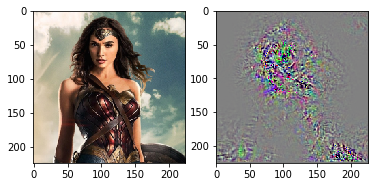

In [32]:
gradient = compute_gradient_single_neuron(vgg.conv5_2, 77)
gradient_norm = utils.normalize(gradient)
montage = utils.montage(np.array(gradient_norm))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(processed_img)
axs[1].imshow(montage)